In [20]:
import requests
import yfinance as yf
import numpy as np
import pandas as pd

from math import floor
import matplotlib.pyplot as plt
# Define the ticker symbols for NSE and NASDAQ
nse_ticker = "^NSEI"   # NSE index symbol
nasdaq_ticker = "^IXIC"   # NASDAQ index symbol

# Fetch historical data using yfinance
nse_data = yf.download(nse_ticker, start="2016-02-01", end="2016-11-01")
nasdaq_data = yf.download(nasdaq_ticker, start="2016-02-01", end="2016-11-01")

# Extract the "Close" prices from the historical data
nse_close_prices = nse_data["Close"]
nasdaq_close_prices = nasdaq_data["Close"]

# Remove any missing values
nse_close_prices = nse_close_prices.dropna()
nasdaq_close_prices = nasdaq_close_prices.dropna()

# # Select overlapping dates
common_dates = nse_close_prices.index.intersection(nasdaq_close_prices.index)
nse_close_prices = nse_close_prices.loc[common_dates]
nasdaq_close_prices = nasdaq_close_prices.loc[common_dates]


# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(nse_close_prices, nasdaq_close_prices)[0, 1]

print("Correlation coefficient between NSE and NASDAQ:", correlation_coefficient)
#This gives correlation coefficent of 0.85 which means positively strongly correlated



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Correlation coefficient between NSE and NASDAQ: 0.92320911850484


## Lead-lag relationship

In [21]:
from scipy.signal import correlate

# Normalize the indices data
normalized_nasdaq = (nasdaq_close_prices - nasdaq_close_prices.mean()) / nasdaq_close_prices.std()
normalized_nse = (nse_close_prices - nse_close_prices.mean()) / nse_close_prices.std()

# Calculate cross-correlation
cross_corr = correlate(normalized_nasdaq, normalized_nse, mode='full')

# Find the lag with the highest correlation
lead_lag = np.argmax(cross_corr) - (len(nasdaq_close_prices) - 1)

if lead_lag > 0:
    print("NASDAQ leads NSE by", lead_lag, "days.")
elif lead_lag < 0:
    print("NSE leads NASDAQ by", -lead_lag, "days.")
else:
    print("NASDAQ and NSE are synchronized.")

NASDAQ and NSE are synchronized.


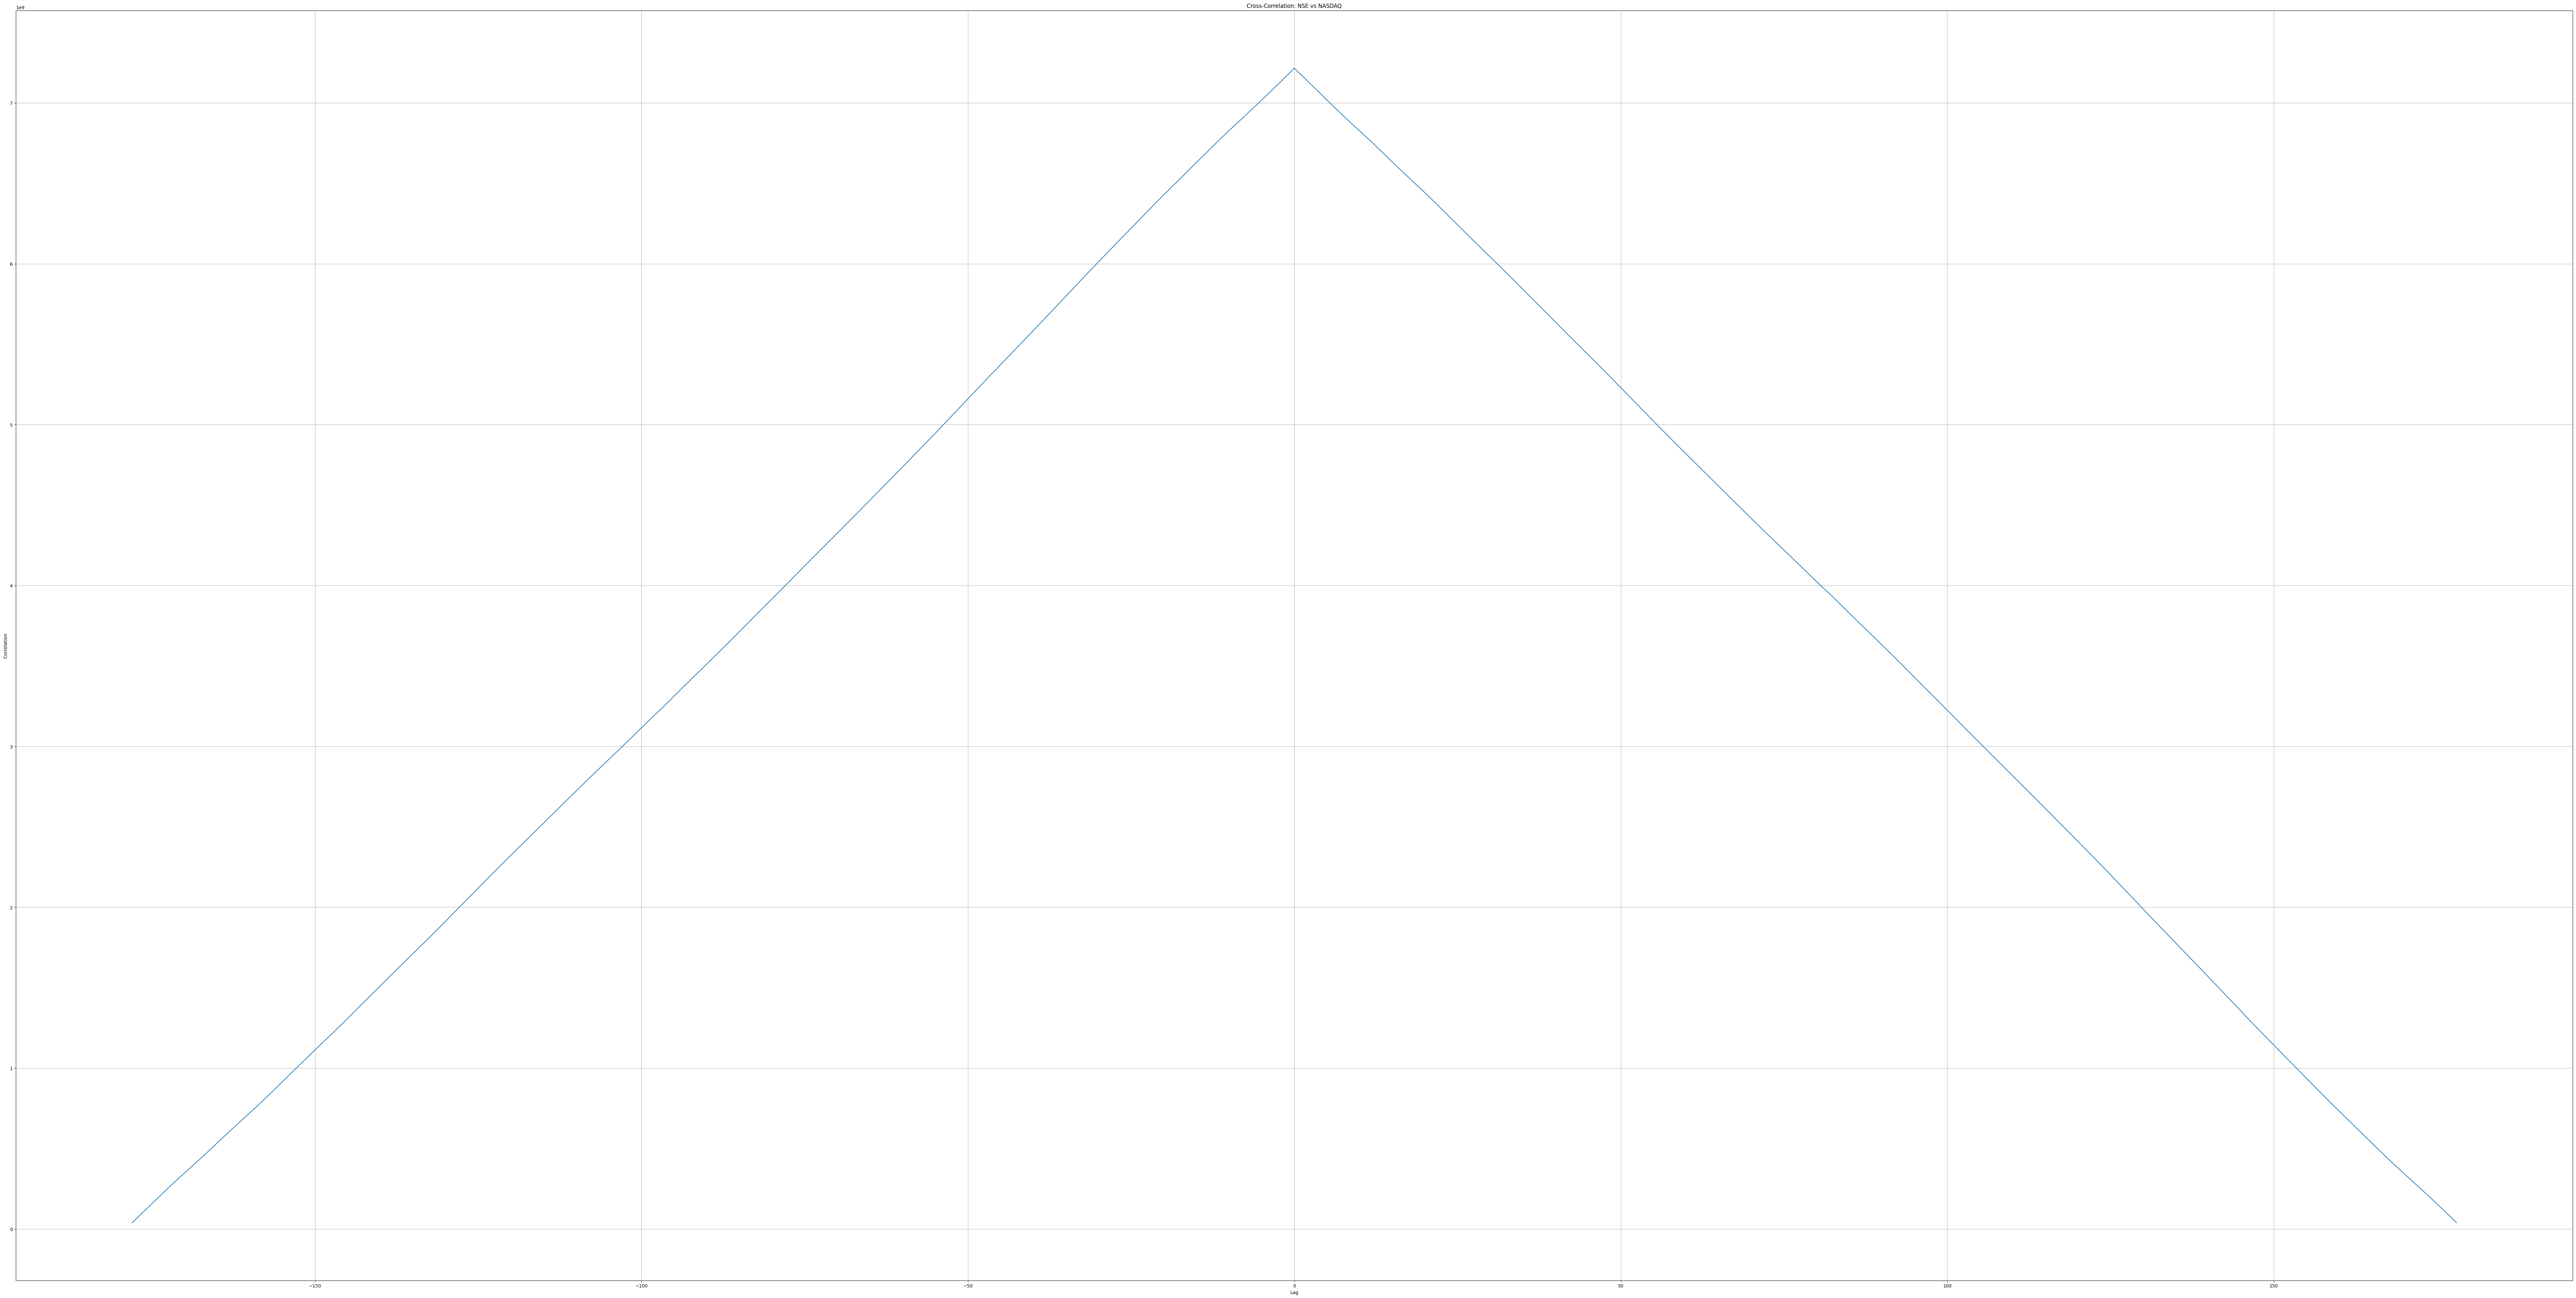

In [22]:
# Calculate cross-correlation
cross_corr = np.correlate(nse_close_prices, nasdaq_close_prices, mode='full')

# Create lag axis for plotting
lags = np.arange(len(cross_corr)) - (len(nse_close_prices) - 1)

# Plot cross-correlation
plt.figure(figsize=(100, 50))
plt.plot(lags, cross_corr)
plt.title('Cross-Correlation: NSE vs NASDAQ')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

As the graph's peak is at zero, I'm choosing NSE for indication coding and optimization of parameters

The lead lag relationship isn't consistent and can change over time , 
Data is taken during period feb1 to nov1 2016

### KELTNER CHANNEL parameter optimization for NSE

In [23]:

def calculate_keltner_channels(data, ema_period, atr_period, multiplier):
    # Calculate EMA
    ema = data['Close'].ewm(span=ema_period, adjust=False).mean()

    # Calculate True Range (TR) and Average True Range (ATR)
    data['High-Low'] = data['High'] - data['Low']
    data['High-PrevClose'] = abs(data['High'] - data['Close'].shift())
    data['Low-PrevClose'] = abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    atr = data['TR'].rolling(window=atr_period).mean()


    # Calculate Keltner Channels
    data['UpperBand'] = ema + (multiplier * atr)
    data['LowerBand'] = ema - (multiplier * atr)
    data['MiddleBand'] = ema

    return data


# Define the parameter ranges to test
ema_periods = [10, 20, 30]
atr_periods = [10, 14, 20]
multipliers = [1.5, 2.0, 2.5]

best_score = float('-inf')
best_parameters = None

# Loop through parameter combinations and evaluate performance
for ema_period in ema_periods:
    for atr_period in atr_periods:
        for multiplier in multipliers:
            # Calculate Keltner Channels for the current parameters
            channels_data = calculate_keltner_channels(nse_data, ema_period, atr_period, multiplier)

            # Performance Metric: Breakout Count
            upper_breakouts = channels_data['Close'] > channels_data['UpperBand']
            lower_breakouts = channels_data['Close'] < channels_data['LowerBand']
            breakout_count = upper_breakouts.sum() + lower_breakouts.sum()

           
            # Performance Metric: Accuracy
            actual_price_direction = nse_data['Close'].diff().shift(-1) > 0  # Positive price change next day
            predicted_price_direction = (channels_data['Close'].diff().shift(-1) > 0) & upper_breakouts | \
                                        (channels_data['Close'].diff().shift(-1) < 0) & lower_breakouts
            accuracy = (actual_price_direction == predicted_price_direction).mean()


            
            # Performance Metric: Profitability
            returns = nse_data['Close'].pct_change().shift(-1)  # Daily returns
            trades = np.where(upper_breakouts, -1, np.where(lower_breakouts, 1, 0))
            profitability = (returns * trades).sum()
            
            

            # Performance Metric: Risk-Adjusted Returns (Sharpe Ratio)
            risk_free_rate = 0.07  # Assuming risk-free rate of 7%
            excess_returns = returns - risk_free_rate
            sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
            if sharpe_ratio > best_score:
                best_score = sharpe_ratio
                best_parameters = (ema_period, atr_period, multiplier)
            
            # Performance Metric: Sortino Ratio
            returns = channels_data['Close'].pct_change().shift(-1)  # Daily returns
            downside_returns = returns[returns < 0]
            downside_std = downside_returns.std()
            sortino_ratio = np.sqrt(252) * (returns.mean() - 0.07) / downside_std  # Assuming risk-free rate of 7% 

            # Performance Metric: Maximum Drawdown
            rolling_max = nse_data['Close'].rolling(window=len(nse_data), min_periods=1).max()
            drawdown = (nse_data['Close'] / rolling_max) - 1
            max_drawdown = drawdown.min()
            
        

print("Best Parameters:")
print(f"EMA Period: {best_parameters[0]}")
print(f"ATR Period: {best_parameters[1]}")
print(f"Multiplier: {best_parameters[2]}")

Best Parameters:
EMA Period: 10
ATR Period: 10
Multiplier: 1.5


##### Keltner Channel Graph

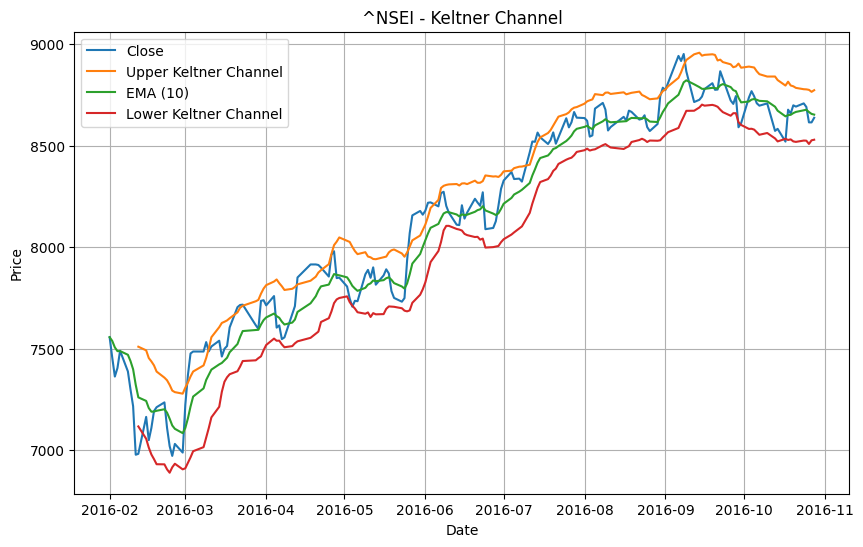

In [24]:
# Calculate the moving average
n = 10  # Number of periods for the moving average
nse_data['MA'] = nse_data['Close'].rolling(n).mean()


# Calculate the EMA line
period = 10
ema = nse_data["Close"].ewm(span=period, adjust=False).mean()

# Calculate the True Range (TR)
nse_data['H-L'] = nse_data['High'] - nse_data['Low']
nse_data['H-PC'] = abs(nse_data['High'] - nse_data['Close'].shift(1))
nse_data['L-PC'] = abs(nse_data['Low'] - nse_data['Close'].shift(1))
nse_data['TR'] = nse_data[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# Calculate the Average True Range (ATR)
m = 10  # Number of periods for the ATR
nse_data['ATR'] = nse_data['TR'].rolling(m).mean()

# Calculate the upper and lower Keltner Channels
k = 1.5  # Keltner Channel multiplier
nse_data['UpperKC'] = nse_data['MA'] + k * nse_data['ATR']
nse_data['LowerKC'] = nse_data['MA'] - k * nse_data['ATR']

# Plot the Keltner Channels
plt.figure(figsize=(10, 6))
plt.plot(nse_data['Close'], label='Close')
plt.plot(nse_data['UpperKC'], label='Upper Keltner Channel')
plt.plot(nse_data.index, ema, label=f"EMA ({period})")
plt.plot(nse_data['LowerKC'], label='Lower Keltner Channel')
plt.title(f"{nse_ticker} - Keltner Channel")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


### BOLLINGER BANDS

Best Parameters: {'ma_window': 10, 'std_multiplier': 1}
Best Max Drawdown: 0.05009654000070722
Best Sharpe Ratio: -120.22901765814557


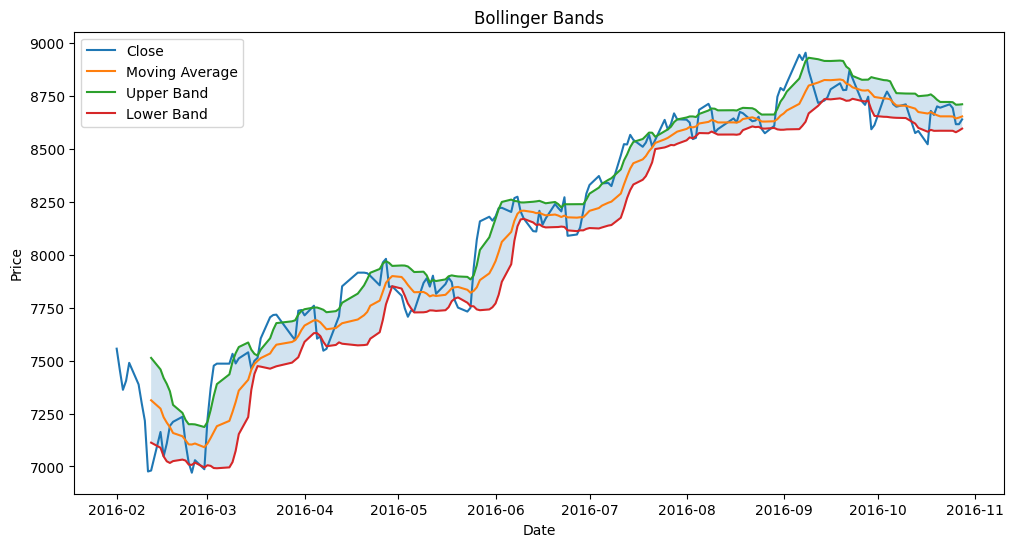

In [25]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid
parameters = {
    'ma_window': [10, 20, 30],
    'std_multiplier': [1, 2, 3]
}

# Initialize variables for best parameters and performance
best_params = None
best_max_drawdown = float('inf')
best_sharpe_ratio = float('-inf')

# Iterate over parameter combinations
for params in ParameterGrid(parameters):
    # Calculate the moving average
    nse_data['MA'] = nse_data['Close'].rolling(window=params['ma_window']).mean()

    # Calculate the standard deviation
    nse_data['STD'] = nse_data['Close'].rolling(window=params['ma_window']).std()

    # Calculate the upper and lower Bollinger Bands
    nse_data['Upper'] = nse_data['MA'] + params['std_multiplier'] * nse_data['STD']
    nse_data['Lower'] = nse_data['MA'] - params['std_multiplier'] * nse_data['STD']

    # Calculate returns
    nse_data['Returns'] = nse_data['Close'].pct_change()

    # Filter signals based on Bollinger Bands
    nse_data['Signal'] = 0
    nse_data.loc[nse_data['Close'] < nse_data['Lower'], 'Signal'] = 1
    nse_data.loc[nse_data['Close'] > nse_data['Upper'], 'Signal'] = -1

    # Calculate strategy returns
    nse_data['StrategyReturns'] = nse_data['Signal'].shift() * nse_data['Returns']

    # Calculate cumulative returns
    nse_data['CumulativeReturns'] = (1 + nse_data['StrategyReturns']).cumprod()

    # Calculate drawdown
    nse_data['Peak'] = nse_data['CumulativeReturns'].cummax()
    nse_data['Drawdown'] = (nse_data['Peak'] - nse_data['CumulativeReturns']) / nse_data['Peak']

    # Calculate maximum drawdown
    max_drawdown = nse_data['Drawdown'].max()

    # Calculate daily returns
    daily_returns = nse_data['Returns']

    # Calculate annualized Sharpe ratio
    sharpe_ratio = np.sqrt(252) * (daily_returns.mean() - 0.07 / daily_returns.std())

    # Update best parameters based on maximum drawdown and Sharpe ratio
    if max_drawdown < best_max_drawdown and sharpe_ratio > best_sharpe_ratio:
        best_max_drawdown = max_drawdown
        best_sharpe_ratio = sharpe_ratio
        best_params = params

# Print the best parameters and performance
print("Best Parameters:", best_params)
print("Best Max Drawdown:", best_max_drawdown)
print("Best Sharpe Ratio:", best_sharpe_ratio)

# Calculate the Bollinger Bands using the best parameters
nse_data['MA'] = nse_data['Close'].rolling(window=best_params['ma_window']).mean()
nse_data['STD'] = nse_data['Close'].rolling(window=best_params['ma_window']).std()
nse_data['Upper'] = nse_data['MA'] + best_params['std_multiplier'] * nse_data['STD']
nse_data['Lower'] = nse_data['MA'] - best_params['std_multiplier'] * nse_data['STD']

# Plot the closing price, moving average, and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(nse_data['Close'], label='Close')
plt.plot(nse_data['MA'], label='Moving Average')
plt.plot(nse_data['Upper'], label='Upper Band')
plt.plot(nse_data['Lower'], label='Lower Band')
plt.fill_between(nse_data.index, nse_data['Upper'], nse_data['Lower'], alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Moving Average Convergence Divergence Indicator For NIFTY50

Best Parameters: {'ema_long': 26, 'ema_short': 12, 'ema_signal': 9}
Best Sharpe Ratio: -120.22901765814557
Best Returns: 0.0026406662604103737
Best Maximum Drawdown: -0.0692339524427329


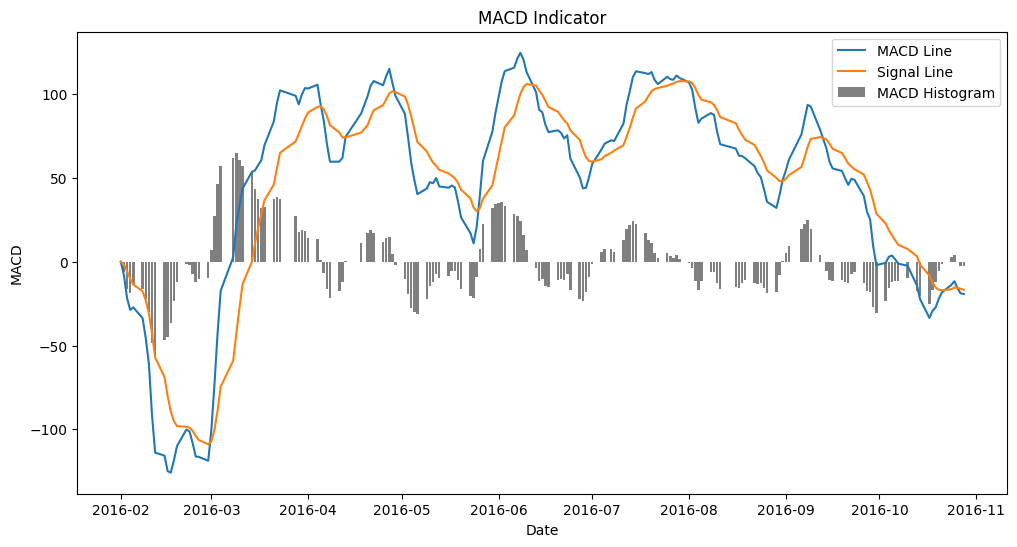

In [26]:

# Define the parameter grid
parameters = {
    'ema_short': [12, 14, 16],
    'ema_long': [26, 28, 30],
    'ema_signal': [9, 12, 15]
}

# Initialize variables for best parameters and performance
best_params = None
best_sharpe_ratio = float('-inf')
best_returns = float('-inf')
best_max_drawdown = float('inf')

# Iterate over parameter combinations
for params in ParameterGrid(parameters):
    # Calculate the MACD line
    nse_data['EMA_short'] = nse_data['Close'].ewm(span=params['ema_short'], adjust=False).mean()
    nse_data['EMA_long'] = nse_data['Close'].ewm(span=params['ema_long'], adjust=False).mean()
    nse_data['MACD_line'] = nse_data['EMA_short'] - nse_data['EMA_long']

    # Calculate the signal line
    nse_data['EMA_signal'] = nse_data['MACD_line'].ewm(span=params['ema_signal'], adjust=False).mean()

    # Calculate the MACD histogram
    nse_data['MACD_histogram'] = nse_data['MACD_line'] - nse_data['EMA_signal']

    # Calculate performance metrics (returns, sharpe ratio, maximum drawdown)
    nse_data['Returns'] = nse_data['Close'].pct_change()
    nse_data['CumulativeReturns'] = (1 + nse_data['Returns']).cumprod()
    nse_data['RollingMax'] = nse_data['CumulativeReturns'].rolling(window=len(nse_data), min_periods=1).max()
    nse_data['Drawdown'] = nse_data['CumulativeReturns'] / nse_data['RollingMax'] - 1
    returns = nse_data['Returns']
    sharpe_ratio = np.sqrt(252) * (returns.mean()-0.07 / returns.std())
    max_drawdown = nse_data['Drawdown'].min()

    # Update best parameters based on performance metrics
    if sharpe_ratio > best_sharpe_ratio and returns[-1] > best_returns and max_drawdown < best_max_drawdown:
        best_sharpe_ratio = sharpe_ratio
        best_returns = returns[-1]
        best_max_drawdown = max_drawdown
        best_params = params

# Print the best parameters and performance metrics
print("Best Parameters:", best_params)
print("Best Sharpe Ratio:", best_sharpe_ratio)
print("Best Returns:", best_returns)
print("Best Maximum Drawdown:", best_max_drawdown)

# Calculate the MACD indicator using the best parameters
nse_data['EMA_short'] = nse_data['Close'].ewm(span=best_params['ema_short'], adjust=False).mean()
nse_data['EMA_long'] = nse_data['Close'].ewm(span=best_params['ema_long'], adjust=False).mean()
nse_data['MACD_line'] = nse_data['EMA_short'] - nse_data['EMA_long']
nse_data['EMA_signal'] = nse_data['MACD_line'].ewm(span=best_params['ema_signal'], adjust=False).mean()
nse_data['MACD_histogram'] = nse_data['MACD_line'] - nse_data['EMA_signal']

# Plot the MACD Line, Signal Line, and Histogram
plt.figure(figsize=(12, 6))
plt.plot(nse_data.index, nse_data['MACD_line'], label='MACD Line')
plt.plot(nse_data.index, nse_data['EMA_signal'], label='Signal Line')
plt.bar(nse_data.index, nse_data['MACD_histogram'], label='MACD Histogram', color='gray')
plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.show()



#### Parameters for Indicators based on optimization
MACD: ema_long : 26 , ema_short : 12, ema_signal: 9
Keltner Channel: EMA Period: 10, ATR Period: 10 , Multiplier: 1.5
Bollinger Bands: MA period:10 , multiplier: 1

In [28]:

# Calculate Keltner Channels
def calculate_keltner_channels(data, window_size, atr_multiplier):
    df = nse_data.copy()
    df['ATR'] = df['High'].rolling(window_size).max() - df['Low'].rolling(window_size).min()
    df['UpperKC'] = df['Close'] + (atr_multiplier * df['ATR'])
    df['LowerKC'] = df['Close'] - (atr_multiplier * df['ATR'])
    return df

# Implement Keltner Channel strategy
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if i == len(prices):
            break
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

# Example usage
# Assuming you have historical price data in a DataFrame named 'data' with columns: Date, Open, High, Low, Close
data = nse_data.copy()
data


,Open,High,Low,Close,Adj Close,Volume,High-Low,High-PrevClose,Low-PrevClose,TR,...,StrategyReturns,CumulativeReturns,Peak,Drawdown,EMA_short,EMA_long,MACD_line,EMA_signal,MACD_histogram,RollingMax
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,7589.500000,7600.450195,7541.250000,7555.950195,7555.950195,200400,59.200195,NaN,NaN,59.200195,...,NaN,NaN,NaN,NaN,7555.950195,7555.950195,0.000000,0.000000,0.000000,NaN
2016-02-02,7566.649902,7576.299805,7428.049805,7455.549805,7455.549805,230200,148.250000,20.349609,127.900391,148.250000,...,-0.0,0.986712,1.000000,0.000000,7540.503981,7548.513129,-8.009148,-1.601830,-6.407318,0.986712
2016-02-03,7392.450195,7419.399902,7350.299805,7361.799805,7361.799805,192000,69.100098,36.149902,105.250000,105.250000,...,-0.0,0.974305,1.000000,-0.012575,7513.011031,7534.682513,-21.671482,-5.615760,-16.055722,0.986712
2016-02-04,7411.450195,7457.049805,7365.950195,7404.000000,7404.000000,222700,91.099609,95.250000,4.150391,95.250000,...,0.0,0.979890,1.000000,-0.006914,7496.240103,7525.002327,-28.762223,-10.245053,-18.517171,0.986712
2016-02-05,7418.250000,7503.149902,7406.649902,7489.100098,7489.100098,249800,96.500000,99.149902,2.649902,99.149902,...,0.0,0.991153,1.000000,0.000000,7495.141641,7522.342902,-27.201261,-13.636294,-13.564967,0.991153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-24,8709.849609,8736.950195,8684.150391,8708.950195,8708.950195,157100,52.799805,43.900391,8.899414,52.799805,...,0.0,1.152595,1.002801,-0.027205,8676.126779,8689.977985,-13.851206,-16.406367,2.555161,1.184828
2016-10-25,8721.700195,8722.650391,8663.450195,8691.299805,8691.299805,189800,59.200195,13.700195,45.500000,59.200195,...,-0.0,1.150259,1.002801,-0.029176,8678.461091,8690.075898,-11.614807,-15.448055,3.833248,1.184828
2016-10-26,8657.299805,8657.299805,8596.599609,8615.250000,8615.250000,219300,60.700195,34.000000,94.700195,94.700195,...,-0.0,1.140194,1.002801,-0.037671,8668.736307,8684.533239,-15.796931,-15.517831,-0.279101,1.184828


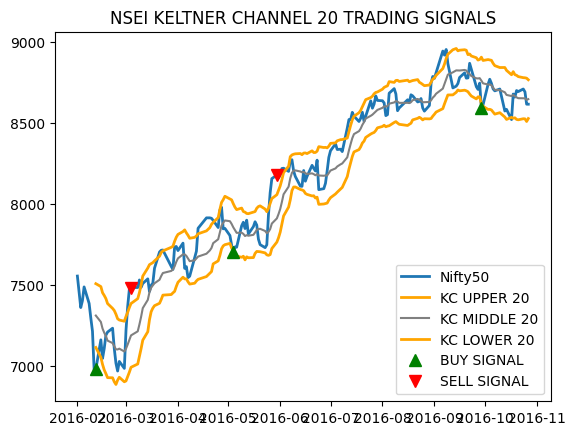

In [29]:

# # Implement Keltner Channel strategy
buy_price, sell_price, kc_signal = implement_kc_strategy(data['Close'], data['UpperKC'], data['LowerKC'])


# PLotting
# TRADING SIGNALS PLOT
data = data[:-1]
plt.plot(data['Close'], linewidth = 2, label = 'Nifty50')
plt.plot(data['UpperKC'], linewidth = 2, color = 'orange', linestyle = '-', label = 'KC UPPER 20')
plt.plot(data['MA'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(data['LowerKC'], linewidth = 2, color = 'orange', linestyle = '-', label = 'KC LOWER 20')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 8, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price, marker = 'v', color= 'r', markersize = 8, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('NSEI KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()

In [33]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(nse_data['Close'],nse_data['Lower'], nse_data['Upper'])

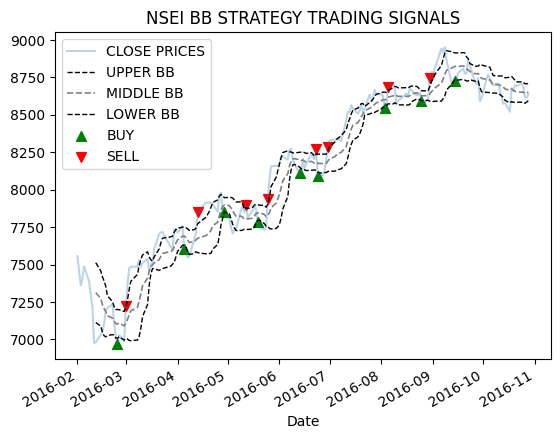

In [36]:
nse_close_prices.plot(label = 'CLOSE PRICES', alpha = 0.3)
nse_data['Upper'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
nse_data['MA'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
nse_data['Lower'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(nse_data.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 50)
plt.scatter(nse_data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 50)
plt.title('NSEI BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()